<a href="https://colab.research.google.com/github/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis/blob/main/code/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Google Colab with GitHub

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

import torchvision
import torch
from torch.utils.data import DataLoader

In [2]:
pwd

'/content'

In [3]:
from google.colab import drive
drive.mount("/content/gdrive/")

path_github = "IMAS_MachineLearning_Workshop-Image_Analysis"
if not os.path.isdir(path_github):
    !git clone https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis.git

%cd IMAS_MachineLearning_Workshop-Image_Analysis/code/

!git fetch
!git pull origin main

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/IMAS_MachineLearning_Workshop-Image_Analysis/code
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 6), reused 8 (delta 4), pack-reused 0
Unpacking objects: 100% (12/12), done.
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
   ba0d509..d5a1dfd  main       -> origin/main
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
 * branch            main       -> FETCH_HEAD
Updating ba0d509..d5a1dfd
Fast-forward
 code/data_augmentation.py |   9 ++-
 code/practice.ipynb       | 192 +++++++++++++++++++++++++++-------------------
 code/training.py          |   6 +-
 3 files changed, 120 insertions(+), 87 deletions(-)


In [4]:
from utils import get_fname_list, get_annotation_info, create_binary_mask, imshow_tensor
from loader import WaldoLoader
from model import Waldo_UNet
from training import train_model
from data_augmentation import Sequence, RandomHorizontalFlip, RandomTranslate

In [5]:
path_dataset_folder = "../dataset"
path_image_folder = "images"
fname_annotation = "annotations.csv"
extension = ".jpg"
ratio_train_dataset = 0.75
int_seed_split = 7109
size_patch = 240
sequence_data_augmentation = Sequence([RandomTranslate(0.2), RandomHorizontalFlip()], probs=0.5)
size_batch = 16

In [6]:
list_fname_im = get_fname_list(root=os.path.join(path_dataset_folder, path_image_folder),
                               extension=extension)
print("Found {} images in the dataset...".format(len(list_fname_im)))

Found 29 images in the dataset...


In [7]:
print("Getting annotations...")
df_annotations = get_annotation_info(path=os.path.join(path_dataset_folder, fname_annotation))
print(df_annotations.head())

Getting annotations...
  filename  width  height  class  xmin  ymin  xmax  ymax
0  001.jpg   2048    1251  waldo   706   513   743   562
1  002.jpg   1286     946  waldo    82   521   107   554
2  003.jpg   2048    1346  waldo  1390   463  1422   500
3  004.jpg   2048    1272  waldo  1484   279  1507   306
4  005.jpg   2100    1760  waldo   882   594   913   634


In [8]:
print("Saving binary mask from annotations as ground-truth...")
for index, row in df_annotations.iterrows():
    fname_im = row["filename"]
    fname_gt = fname_im.split(extension)[0] + "_gt.png"
    path_gt = os.path.join(path_dataset_folder, path_image_folder, fname_gt)
    if not os.path.isfile(path_gt):
        print("... Ground-truth of: {} ...".format(fname_im))
        mask = create_binary_mask(bbox_coords=row[["xmin", "ymin", "xmax", "ymax"]],
                              im_ref_width=row["width"],
                              im_ref_height=row["height"])
        plt.imsave(path_gt, mask, cmap='gray')

Saving binary mask from annotations as ground-truth...


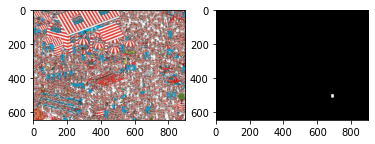

In [9]:
fig = plt.figure()

plt.subplot(1, 2, 1)
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_im))
np_im = np.array(im)
plt.imshow(np_im)

plt.subplot(1, 2, 2)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_im.split(".jpg")[0] + "_gt.png"))
np_gt = np.array(gt)
plt.imshow(np_gt)

plt.show()

In [10]:
print("Splitting dataset between Training / Validation / Testing...")
df_fname = df_annotations.drop_duplicates("filename")["filename"]
df_fname_train, df_fname_validate = \
    np.split(df_fname.sample(frac=1, random_state=int_seed_split), [int(ratio_train_dataset*len(df_fname))])
df_annotations["subset"] = "training"
df_annotations.loc[df_annotations["filename"].isin(df_fname_validate), "subset"] = "validation"

print(df_annotations.head())

Splitting dataset between Training / Validation / Testing...
  filename  width  height  class  xmin  ymin  xmax  ymax      subset
0  001.jpg   2048    1251  waldo   706   513   743   562    training
1  002.jpg   1286     946  waldo    82   521   107   554    training
2  003.jpg   2048    1346  waldo  1390   463  1422   500    training
3  004.jpg   2048    1272  waldo  1484   279  1507   306  validation
4  005.jpg   2100    1760  waldo   882   594   913   634    training


In [11]:
width_largest = df_annotations["width"].max()
height_ = df_annotations[df_annotations["width"] == width_largest]["height"].tolist()[0]
size_img = (width_largest, height_)

In [12]:
list_fname_train = df_annotations[df_annotations["subset"] == "training"]["filename"]
list_path_img_train = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_train])
list_path_gt_train = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_train])
dataset_train = WaldoLoader(list_path_img=list_path_img_train,
                            list_path_gt=list_path_gt_train,
                            size_img=size_img,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=sequence_data_augmentation)

Resizing all images to same dimensions: (2953, 2088) pixels^2 ...


In [13]:
list_fname_valid = df_annotations[df_annotations["subset"] == "validation"]["filename"]
list_path_img_valid = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_valid])
list_path_gt_valid = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_valid])
dataset_valid = WaldoLoader(list_path_img=list_path_img_valid,
                            list_path_gt=list_path_gt_valid,
                            size_img=size_img,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=None)

Resizing all images to same dimensions: (2953, 2088) pixels^2 ...


In [14]:
len(dataset_train), len(dataset_valid)

(2574, 1053)

In [15]:
loader_train = DataLoader(dataset_train, batch_size=size_batch, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=size_batch, shuffle=True)

280.0 0
0.0 0
0.0 0
4234.0 4234
4346.0 4346
0.0 0
0.0 0
1848.0 1848
5032.0 5032
4234.0 4234
1230.0 1230
2668.0 2668
2494.0 2494
0.0 0
0.0 0
2494.0 2494
tensor(7.8590e-09) tensor(1.0000)
tensor([0., 1.], dtype=torch.float64) torch.Size([16, 1, 240, 240]) torch.Size([16, 3, 240, 240])


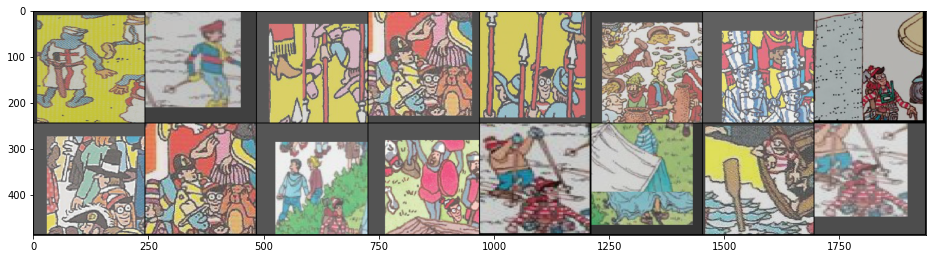

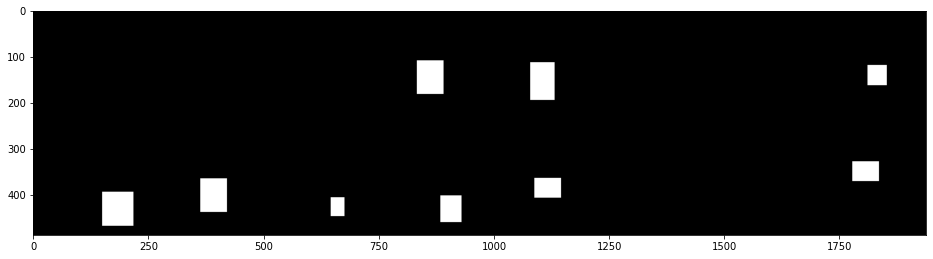

In [16]:
image_expl, label_expl = iter(loader_train).next()
print(image_expl.mean(), image_expl.std())
print(label_expl.unique(), label_expl.size(), image_expl.size())
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(image_expl, normalize=True))
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(label_expl))

In [ ]:
model = Waldo_UNet(n_channels=3).cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [ ]:
model_trained = train_model(model,optimizer, loader_train, dataset_validation=loader_valid, n_epoch=15)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch#0 -- Train loss: -0.016 -- Validation loss: -0.0
Epoch#1 -- Train loss: -0.006 -- Validation loss: -0.0
Epoch#2 -- Train loss: -0.054 -- Validation loss: -0.0
Epoch#3 -- Train loss: -0.064 -- Validation loss: -0.0
Epoch#4 -- Train loss: -0.014 -- Validation loss: -0.001
Epoch#5 -- Train loss: -0.052 -- Validation loss: -0.0
Epoch#6 -- Train loss: -0.02 -- Validation loss: -0.0
Epoch#7 -- Train loss: -0.004 -- Validation loss: -0.001
Epoch#8 -- Train loss: -0.008 -- Validation loss: -0.001
Epoch#9 -- Train loss: 0.017 -- Validation loss: -0.0
Epoch#10 -- Train loss: -0.001 -- Validation loss: -0.0
Epoch#11 -- Train loss: -0.001 -- Validation loss: -0.0
Epoch#12 -- Train loss: -0.001 -- Validation loss: -0.0
Epoch#13 -- Train loss: -0.001 -- Validation loss: -0.0
Epoch#14 -- Train loss: -0.001 -- Validation loss: -0.0


UnboundLocalError: ignored

In [ ]:
921600 * 2